# Semantic Segmentation with Unet++

## Prepare

In [1]:
!pip install torchinfo
!pip install -U segmentation-models-pytorch

     |████████████████████████████████| 88 kB 3.0 MB/s             
     |████████████████████████████████| 58 kB 5.6 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 376 kB 40.1 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=da110695668ae1632fdb347a82c48e921ce773f191af86c21ecd583ae2456597
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=b6a48359feee1c11667c2f276b123c3377931bcee4206974f8c635861120077f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import os
import json
import numpy as np
import pandas as pd
import nibabel as nib
# DL
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import models
# Visualization
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import seaborn as sns

In [3]:
PATH = "../input/tgcovid"

In [4]:
def expand_path(*right_part):
    def _expand_path(left_part):
        return os.path.join(*right_part, left_part)
    return _expand_path

def load_data(json_file):
    datapath = os.path.join(PATH, "data", "data")
    path_images = os.path.join(datapath, 'images')
    path_labels = os.path.join(datapath, 'labels')
    with open(os.path.join(PATH, json_file), 'r') as f:
        dict_data = json.load(f)

    data = pd.DataFrame(dict_data)
    # expand path to full
    data["image"] = data["image"].apply(expand_path(path_images))
    data["label"] = data["label"].apply(expand_path(path_labels))
    # remove .gz
    data["image"] = data["image"].str[:-3]
    data["label"] = data["label"].str[:-3]
    return data

In [5]:
training_data = load_data('training_data.json')

In [6]:
class CovidDataset2D(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        for idx in tqdm(range(len(data))):
            image = self.load_data(data.iloc[idx, 0], "float32")
            mask = self.load_data(data.iloc[idx, 1], "int16")
            for idy in range(image.shape[-1]):
                self.images.append(image[..., idy, np.newaxis])
                self.labels.append(mask[..., idy, np.newaxis])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.labels[idx]
        
        image = self.normalize(image)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
            mask = mask[None, ...]
            
        return image, mask
    
    def load_data(self, path, dtype="float32"):
        return nib.load(path).get_fdata().astype(dtype)
    
    def normalize(self, x):
        return normalize(x)

In [7]:
full_dataset = CovidDataset2D(training_data)

  0%|          | 0/40 [00:00<?, ?it/s]

## Data 

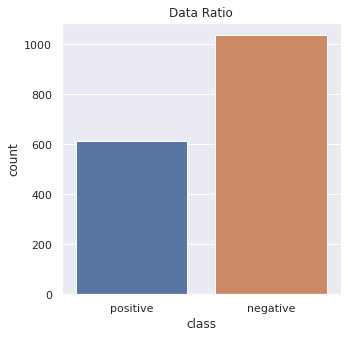

In [8]:
def viz_classes_ratio(dataset, figsize=(5, 5)):   
    positive = 0
    n_labels = len(full_dataset.labels)
    for mask in full_dataset.labels:
        positive += int(np.sum(mask) > 0)
    
    negative = n_labels - positive
    
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=["positive", "negative"], y=[positive, negative], ax=ax)
    ax.set_title("Data Ratio")
    ax.set_xlabel("class")
    ax.set_ylabel("count")
    plt.show()
    
viz_classes_ratio(full_dataset)

## Visualization 

In [9]:
def normalize(x):
    min_in = np.min(x)
    max_in = np.max(x)
    return (x - min_in) / (max_in - min_in + 1e-8)

def slice2rgb(image, normalize_data=True):
    image = image.astype(np.float32)
    image = normalize(image) if normalize_data else image
    image *= 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    return Image.fromarray(image)

def mask2blue(mask):
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.fromarray(mask)
    
def blend(image, mask, normalize_data=True):
    return Image.blend(
        slice2rgb(image, normalize_data=True),
        mask2blue(mask),
        alpha=.2
    )

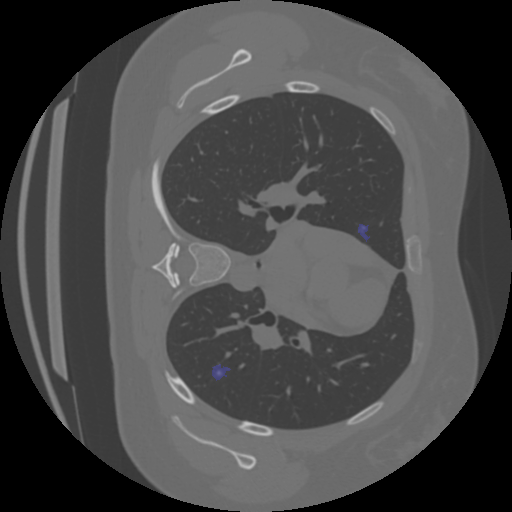

In [10]:
# Visualize slices
IDX = 21

image = full_dataset.images[IDX]
mask = full_dataset.labels[IDX]
display(blend(image, mask))

Sum of all masks


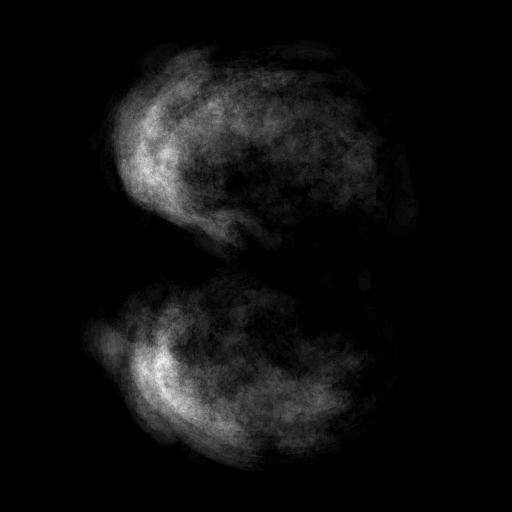

In [11]:
DISPLAY_LABELS = False
DISPLAY_ALL = False

sum_arr = np.zeros((512, 512))
for idx, l in enumerate(full_dataset.labels):
    l_sum = l.sum(axis=-1)
    if DISPLAY_LABELS:
        if (DISPLAY_ALL or np.sum(l_sum) > 0):
            print("Mask №%d" % idx)
            display(slice2rgb(l_sum))
    sum_arr += l_sum

print("Sum of all masks")
display(slice2rgb(sum_arr)) 

## Data Loader and Augmentations

In [12]:
IMG_SIZE = (512, 512)
BATCH_SIZE = 8
SHUFFLE = True
N_WORKERS = 2
TEST_RATIO = .2

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_test = A.Compose([
    A.Resize(*IMG_SIZE),
    ToTensorV2()
])

transform_train = A.Compose([
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5), 
    A.ShiftScaleRotate(
            rotate_limit=60, shift_limit=0.15, 
            scale_limit=.1, border_mode=0, p=.4),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120*.13, alpha_affine=120*.1, border_mode=0, p=.1),
        A.GridDistortion(border_mode=0, p=.6),
        A.OpticalDistortion(distort_limit=.7, shift_limit=.4, border_mode=0, p=.3)    
    ], p=.3),
    A.OneOf([
        A.CoarseDropout(),
        A.GaussianBlur(),
    ], p=.1),
    A.RandomBrightnessContrast(contrast_limit=0, p=.2),
    A.OneOf([
        A.Resize(*IMG_SIZE),
        A.RandomSizedCrop((300, 512), *IMG_SIZE),
    ], p=1),
    ToTensorV2()
])

In [15]:
def train_test_split(data):
    n = len(data)
    idx_split = n - int(n*TEST_RATIO)
    return data.iloc[:idx_split], data.iloc[idx_split:]

In [16]:
train, test = train_test_split(training_data)

In [17]:
full_dataset.transform = transform_train
train_dataset = CovidDataset2D(train, transform_train)
test_dataset = CovidDataset2D(test, transform_test)
# loaders
dataloader_train = DataLoader(train_dataset, BATCH_SIZE, SHUFFLE, num_workers=N_WORKERS)
dataloader_test = DataLoader(test_dataset, BATCH_SIZE, num_workers=N_WORKERS)
dataloader_full = DataLoader(full_dataset, BATCH_SIZE, SHUFFLE, num_workers=N_WORKERS)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

## Model

In [18]:
# My implementation Unet with vgg encoder
class UNet_vgg(nn.Module):
    def get_up_layer(self, features_in, features_out):
        return nn.Sequential(
            nn.Dropout(),
            nn.BatchNorm2d(features_in),
            nn.Conv2d(features_in, features_out, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(features_out),
            nn.Conv2d(features_out, features_out, 3, padding=1),
            nn.ReLU(),
        )
    
    def get_deconv(self, features):
        return nn.ConvTranspose2d(features, features, 4, stride=2, padding=1)
    
    def __init__(self, pretrain=True):
        super().__init__()
        
        backbone = models.vgg13_bn(pretrain).features
        self.down_layers = []
        
        max_depth = 4
        # get down layers
        depth = 0
        i = 0
        for j in range(len(backbone)):
            if isinstance(backbone[j], nn.MaxPool2d):
                self.down_layers.append(backbone[i:j])
                i = j
                depth += 1
            if depth == max_depth:
                break
                
        self.down_layers[0][0] = nn.Conv2d(1, 64, 3, padding=1)
        self.down_layers = nn.Sequential(*self.down_layers)
        
        # get up layers
        self.up_layers = nn.ModuleList([
            self.get_up_layer(512+256, 256),
            self.get_up_layer(256+128, 128),
            self.get_up_layer(128+64, 64),
        ])
        self.deconv_layers = nn.ModuleList([
            self.get_deconv(512),
            self.get_deconv(256),
            self.get_deconv(128),
        ])
        
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        saved_x = []
        for down in self.down_layers[:3]:
            x = down(x)
            saved_x.append(x.clone())
        
        x = self.down_layers[3](x)
        
        for up, deconv, conx in zip(self.up_layers, self.deconv_layers, saved_x[::-1]):
            x = deconv(x)
            x = up(torch.cat([conx, x], dim=1))
            
        return self.final(x)

In [19]:
from segmentation_models_pytorch import UnetPlusPlus

model = UnetPlusPlus(
    encoder_name="timm-efficientnet-b3", encoder_depth=5, encoder_weights="imagenet", 
    in_channels=1, classes=1, activation="sigmoid", decoder_channels=(256, 128, 64, 32, 16),
).to(device)

try:
    print(summary(model, (1, 1, *IMG_SIZE)))
except:
    print("Something go wrong with Summary.")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_aa-84b4657e.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_aa-84b4657e.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
UnetPlusPlus                                       --                        --
├─EfficientNetEncoder: 1-1                         [1, 1, 512, 512]          --
│    └─Conv2d: 2-1                                 [1, 40, 256, 256]         360
│    └─BatchNorm2d: 2-2                            [1, 40, 256, 256]         80
│    └─Swish: 2-3                                  [1, 40, 256, 256]         --
│    └─Sequential: 2                               --                        --
│    │    └─Sequential: 3-1                        [1, 24, 256, 256]         3,504
│    │    └─Sequential: 3-2                        --                        (recursive)
│    │    └─Sequential: 3-3                        [1, 32, 128, 128]         48,118
│    │    └─Sequential: 3-4                        [1, 48, 64, 64]           110,912
│    │    └─Sequential: 3-5                        [1, 96, 32, 32]           638,700
│    │  

## Losses

In [20]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=.5, beta=None, gamma=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta or (1-alpha)
        self.gamma = gamma
        self._smooth = 1
        
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tp = (inputs * targets).sum()
        fp = (inputs * (1-targets)).sum()
        fn = ((1-inputs) * targets).sum()
        
        tversky = (tp+self._smooth)/(tp+self.alpha*fp+self.beta*fn+self._smooth)
        return torch.pow(1-tversky, self.gamma)
        

## Metrics

In [21]:
def dice_metric(out, mask):
    out = out.reshape(-1, *IMG_SIZE)
    mask = mask.reshape(-1, *IMG_SIZE)
    interseption = (out * mask).float().sum((1, 2))
    union = (out + mask).float().sum((1, 2))
    dice = (2*interseption + 1e-8)/(union + 1e-8)
    return dice

## Log

In [22]:
# for i in range(50, 100):
#     print(i)
#     display(blend(*[x.detach().cpu().numpy().reshape(*IMG_SIZE) for x in full_dataset[i]]))

In [23]:
n_samples_val = np.random.randint(0, len(test_dataset), size=3)
n_samples_train = np.random.randint(0, len(train_dataset), size=3)

imgs = []
masks = []
for i in n_samples_val:
    img, mask = test_dataset[i]
    imgs.append(img)
    masks.append(mask)
for i in n_samples_train:
    img, mask = train_dataset[i]
    imgs.append(img)
    masks.append(mask)

In [24]:
def plot_samples(imgs, masks, threshold=None, figc=(10., 5.)):
    # support func
    to_np = lambda x: x.detach().cpu().numpy().reshape(*IMG_SIZE)
    
    fig = plt.figure(figsize=(len(imgs)*figc[0], 3*figc[1]))
    grid = ImageGrid(
        fig, 111, 
        nrows_ncols=(len(imgs), 3),
        axes_pad=0.05
    )
    grid[0].set_title("Input")
    grid[1].set_title("Output")
    grid[2].set_title("Ground Truth")
    axes_iter = iter(grid)
    for img, mask in zip(imgs, masks):
        np_img = to_np(img)
        np_mask = to_np(mask)
        model.eval()
        pred = model(img[None, ...].to(device))
        model.train()
        pred = pred > threshold if threshold is not None else pred
        np_pred = to_np(pred)
        
        ax_inp = next(axes_iter)
        ax_inp.imshow(slice2rgb(np_img, normalize_data=True))
        ax_inp.set_axis_off()
        
        ax_out = next(axes_iter)
        ax_out.imshow(blend(np_img, np_pred, normalize_data=True))
        ax_out.set_axis_off()
        
        ax_grdtruth = next(axes_iter)
        ax_grdtruth.imshow(blend(np_img, np_mask, normalize_data=True))
        ax_grdtruth.set_axis_off()
    plt.show()

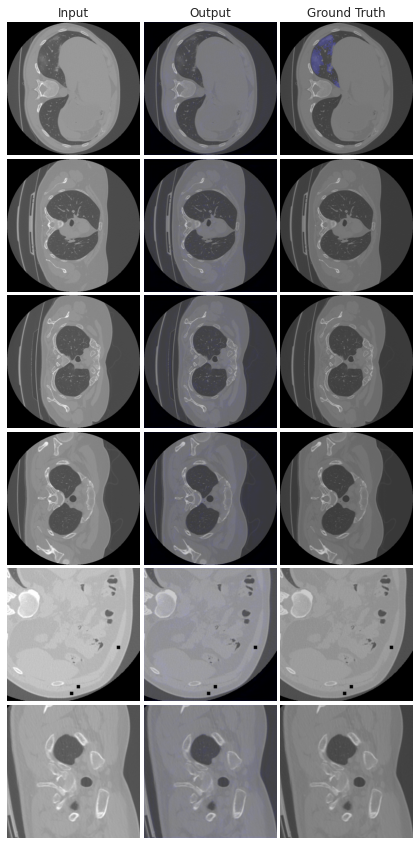

In [25]:
plot_samples(imgs, masks, figc=(10., 5.))

In [26]:
def plot_dice(train, test=None, title=None, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(1, len(train)+1), y=train, 
                 ax=ax, label="train")
    if test is not None:
        sns.lineplot(x=range(1, len(test)+1), y=test, 
                     ax=ax, label="validation")
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel("dice")
    plt.show()

In [27]:
def plot_grads(grads, title=None, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(len(grads)), y=grads, ax=ax)
    ax.set_title(title)
    plt.show()

In [28]:
def plot_loss(train, test=None, title=None, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(1, len(train)+1), y=train, ax=ax, label="train")
    if test is not None:
        sns.lineplot(x=range(1, len(test)+1), y=test, ax=ax, label="validation")
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.show()

## Training

In [29]:
LEARNING_RATE = 1e-4
EPOCHS = 200
FULL_DATASET = True
SCHEDULE_STEP = 20
SCHEDULE_GAMMA = .9

UPDATE_EVERY_N = 10
THRESHOLD = .9
# if None mean non clip, else clip by norm=CLIP_GRAD_NORM
CLIP_GRAD_NORM = 40

In [30]:
criterion = FocalTverskyLoss(.3)
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE)
schedule = torch.optim.lr_scheduler.StepLR(
    optimizer, SCHEDULE_STEP, gamma=SCHEDULE_GAMMA) if SCHEDULE_STEP else None

In [31]:
def train_model(model, train_loader, val_loader=None):
    history = {
        "train_loss":[], "val_loss":[], 
        "val_dice":[], "train_dice":[], 
        "grads":[],
    }
    for epoch in range(1, 1+EPOCHS):
        print("epoch", epoch)
        # Train
        train_loss_sum = 0
        train_dice_sum = 0
        for i, (image, mask) in enumerate(train_loader):
            image = image.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            pred_mask = model(image)
            loss = criterion(pred_mask, mask)
            loss.backward()
            dice = dice_metric(pred_mask > THRESHOLD, mask)

            if CLIP_GRAD_NORM is not None:
                history["grads"].append(torch.nn.utils.clip_grad_norm_(
                    model.parameters(), CLIP_GRAD_NORM).item())

            optimizer.step()

            train_loss_sum += loss.item()
            train_dice_sum += torch.sum(dice).item()/BATCH_SIZE

        train_mean_loss = train_loss_sum/(i+1)
        train_dice_mean = train_dice_sum/(i+1)

        history["train_loss"].append(train_mean_loss)
        history["train_dice"].append(train_dice_mean)

        # Validation
        if val_loader is not None:
            with torch.no_grad():
                val_dice_sum = 0
                val_sum_loss = 0
                model.eval()
                for i, (image, mask) in enumerate(val_loader):
                    image = image.to(device)
                    mask = mask.to(device)

                    pred_mask = model(image)
                    loss = criterion(pred_mask, mask)
                    dice = dice_metric(pred_mask > THRESHOLD, mask)

                    val_sum_loss += loss.item()
                    val_dice_sum += torch.sum(dice).item()/BATCH_SIZE
                model.train()

            val_dice_mean = val_dice_sum/(i+1)
            val_mean_loss = val_sum_loss/(i+1)

            history["val_loss"].append(val_mean_loss)
            history["val_dice"].append(val_dice_mean)

        # print log
        print("Train Dice Metric: %.4f" % train_dice_mean)
        print("Train Loss: %.4f" % train_mean_loss)
        if val_loader is not None:
            print("Validation Dice Metric: %.4f" % val_dice_mean)
            print("Validation Loss: %.4f" % val_mean_loss)
        if epoch%UPDATE_EVERY_N==0:
            clear_output(wait=True)
            
#             plot_grads(history["grads"])
                
            plot_loss(history["train_loss"], history["val_loss"], "Loss")
            plot_dice(history["train_dice"], history["val_dice"], "Dice Metric")
            plot_samples(imgs, masks, figc=(10., 5.), threshold=THRESHOLD)
            
        if schedule is not None:
            schedule.step()
    return history
                

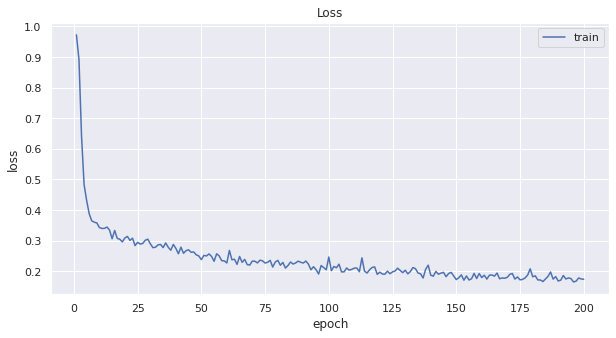

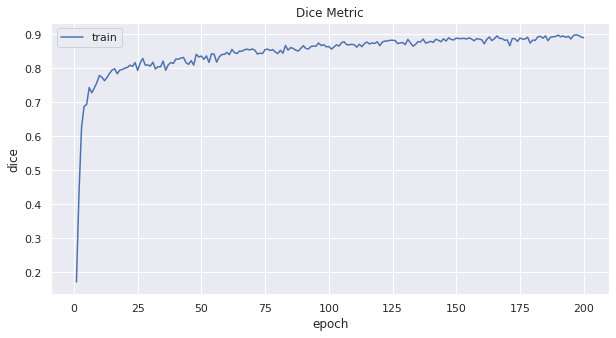

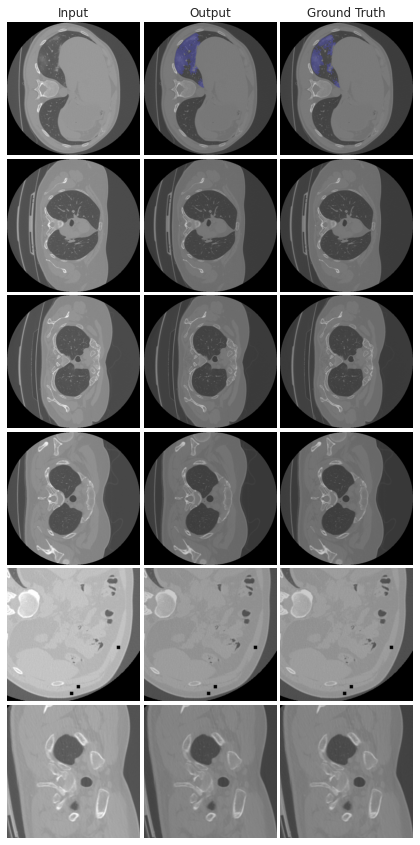

In [32]:
if not FULL_DATASET:
    history = train_model(model, dataloader_train, dataloader_test)
else:
    history = train_model(model, dataloader_full, None)

In [33]:
print("Best dice metric on train: %.4f" % max(history["train_dice"]))
print("Best loss on train: %.4f" % min(history["train_loss"]))
if len(history["val_dice"]) > 0:
    print("Best dice metric on validation: %.4f" % max(history["val_dice"]))
    print("Best loss on validation: %.4f" % min(history["val_loss"]))

Best dice metric on train: 0.8983
Best loss on train: 0.1650


In [34]:
"""
Load testing data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
"""
testing_data = load_data("testing_data.json")

images_testig = []
for idx in tqdm(range(len(testing_data))):
    image = nib.load(testing_data.iloc[idx, 0])
    images_testig.append(image.get_fdata())

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
"""
Write your code here

You need to:
 1. Predict labels for CT scans from images list
 2. Store them in the labels_predicted list in form of numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""
def make_predictions(model, threshold=.9):
    labels_predicted = []
    with torch.no_grad():
        model.eval()
        for X in images_testig:
            Y = []
            for idx in range(X.shape[-1]):
                x = full_dataset.normalize(X[..., idx]).astype("float32")
                x = transform_test(image=x)["image"][None, ...]
                pred = model(x.to(device))
                if pred.shape[-2:] != (512, 512):
                    pred = nn.functional.interpolate(pred, size=(512, 512))
                Y.append(
                    (pred > threshold).cpu().numpy().astype("int").reshape(512, 512)
                )
            labels_predicted.append(np.dstack(Y))
        model.train()
    return labels_predicted

labels_predicted = make_predictions(model, threshold=.9)

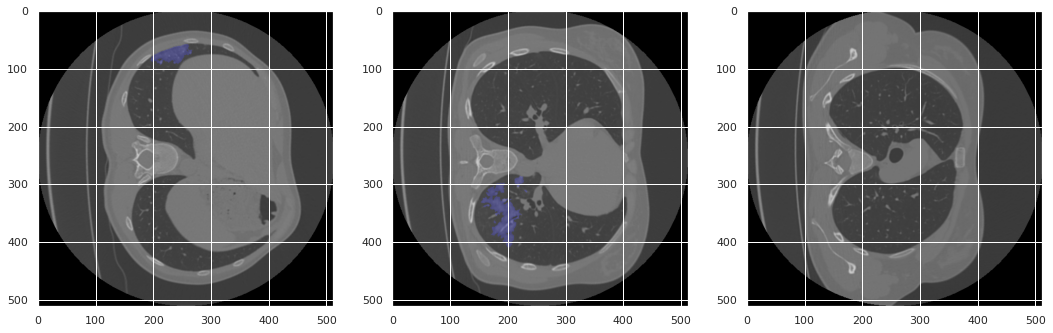

In [36]:
# Visualize some of the predictions

patient_num = 1
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_testig[patient_num][..., idx],
        labels_predicted[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [37]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open(os.path.join(PATH, 'testing_data.json'), 'r') as f:
    dict_testing = json.load(f)

with open(f'submission.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, labels_predicted)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])

0it [00:00, ?it/s]

Result


Run
27473.1s - GPU

Private Score
**0.67155**

Public Score
**0.65472**